# Fine Tuning (VGG16)

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cat_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

68616192/68606236 [==============================] - 0s 0us/step


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def ImageDataGenerate(train_dir, validation_dir):

    batch_size = 32
    IMG_HEIGHT = 224
    IMG_WIDTH = 224

    """data generator"""
    train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        width_shift_range=0.1,
        height_shift_range=0.1,
    )

    validation_image_generator = ImageDataGenerator(rescale=1./255)

    """data"""
    train_data_gen = train_image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=train_dir,
        shuffle=True,
        target_size=(IMG_HEIGHT,IMG_WIDTH),
        class_mode="binary",
    )

    val_data_gen = validation_image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode="binary",
    )

    return train_data_gen, val_data_gen



# Create model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def train_FClayer(train_data_gen, val_data_gen):
    image_size = len(train_data_gen[0][0][0])
    input_shape = (image_size, image_size, 3)
    batch_size = len(train_data_gen[0][0])
    total_train = len(train_data_gen) * batch_size
    total_validate = len(val_data_gen) * batch_size

    pre_trained_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
    )

    for layer in pre_trained_model.layers[:15]:
        layer.trainable = False
    
    for layer in pre_trained_model.layers[15:]:
        layer.trainable = True
    
    model = Sequential()

    model.add(pre_trained_model)

    model.add(
        GlobalMaxPooling2D()
    )

    model.add(
        Dropout(0.5)
    )

    model.add(
        Dense(
            512,
            activation="relu",
        )
    )

    model.add(Dropout(0.5))

    model.add(
        Dense(
            1,
            activation="sigmoid",
        )
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.RMSprop(learning_rate=1e-5),
        metrics=["accuracy"]
    )

    model.summary()

    def step_decay(epoch):
        initial_lrate = 0.00001
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(
            drop,
            math.floor((epoch)/epochs_drop),
        )
        return lrate
    
    lrate = LearningRateScheduler(step_decay)

    epochs = 40
    history = model.fit(
        train_data_gen,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_validate // batch_size,
        steps_per_epoch=total_train // batch_size,
        verbose=1,
        callbacks=[lrate],
    )

    return history

    

In [4]:
%%time

train_data_gen, val_data_gen = ImageDataGenerate(train_dir, validation_dir)
history = train_FClayer(train_data_gen, val_data_gen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                       

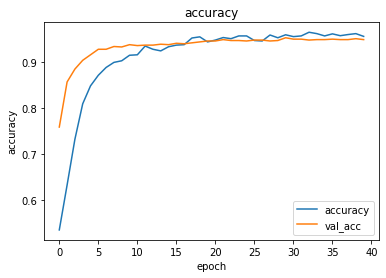

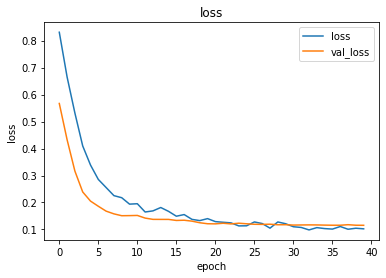

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    plt.plot(history.history["accuracy"],"-",label="accuracy")
    plt.plot(history.history["val_accuracy"],"-",label="val_acc")
    plt.title("accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="lower right")
    plt.show()

    plt.plot(history.history["loss"],"-",label="loss")
    plt.plot(history.history["val_loss"],"-",label="val_loss")
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper right")
    plt.show()

plot_acc_loss(history)
